In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# IMPORTS
import csv
import re
import zipfile
import pickle
import os
from io import BytesIO
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
plt.style.use('ggplot')

import spacy
#python -m spacy download el_core_news_sm -- rin in cmd
nlp = spacy.load("el_core_news_sm")
nlp.max_length = 3000000

import nltk
#nltk.download("punkt")
import string
from nltk import WhitespaceTokenizer

from gensim.models import KeyedVectors, Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Read training data
train_domains = list()
y_train = list()
with open("train.txt", 'r') as f:
    for line in f:
        l = line.split(',')
        train_domains.append(l[0])
        y_train.append(int(l[1][:-1]))

# Read test data
test_domains = list()
with open("test.txt", 'r') as f:
    for line in f:
        l = line.split(',')
        test_domains.append(l[0])

In [4]:
# Load data 
with open('X_train_text_d2v', 'rb') as handle:
    X_train_text = pickle.load(handle)
with open('X_train_graph', 'rb') as handle:
    X_train_graph = pickle.load(handle)
    
    
with open('X_test_text_d2v', 'rb') as handle:
    X_test_text = pickle.load(handle)
with open('X_test_graph', 'rb') as handle:
    X_test_graph = pickle.load(handle)

X_train_text.shape, X_train_graph.shape, X_test_text.shape, X_test_graph.shape

((1258, 32), (1258, 32), (547, 32), (547, 32))

In [5]:
#Creating dictionaries to use in the confusion matrix

#Defining dictionary for 10 types of clases
classes = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4',
               5:'5', 6:'6', 7:'7', 8:'8', 9:'9'}

#Defining dictionary that holds two types of model
models = {0: "Naive Bayes",1: "Random Forest",2: "LightGBM",3: "Logistic Regression",4: "MLP",5 : "CNN"}

In [6]:
#Building function to plot the confusion matrix as a heatmap
def conf_matr(y_t,y_pred,class_index,classes_dict=classes,model_dict=models):
    #Confusion matrix
    conf_m = confusion_matrix(y_t,y_pred)

    #Building data frame to 
    df_cm = pd.DataFrame(conf_m, index = [i for i in classes_dict.values()],
                  columns = [i for i in classes_dict.values()])
    fig,ax = plt.subplots(figsize=(10,10))
    sns.heatmap(df_cm, annot=True, cmap='Greens',fmt='.3g',cbar=False)
    
    ax.set_xlabel('Predicted classes', fontsize=14, weight='bold')
    ax.set_ylabel('True classes', fontsize=14, weight='bold')
    ax.set_title(f'Confusion matrix of {model_dict[class_index]} classifier', fontsize=17, weight='bold')

    plt.show()

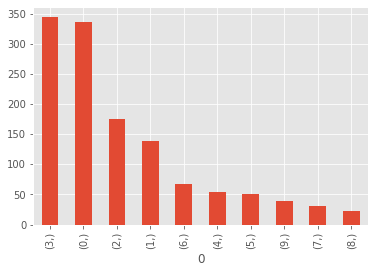

In [8]:
pd.DataFrame(list(map(int, y_train))).value_counts().plot.bar(); #imbalanced dataset

In [9]:
y_train = np.array(list(map(int, y_train)))

X_train_text, X_val_text, y_train_text, y_val_text = train_test_split(
    X_train_text, y_train, test_size=0.2, random_state=123, stratify=y_train)
X_train_graph, X_val_graph, y_train_graph, y_val_graph = train_test_split(
    X_train_graph, y_train, test_size=0.2, random_state=123, stratify=y_train)

# y_train and y_val are the same for text and graph

### Combine Graph and Text 

Doc2Vec and Node2Vec - 32 dimensions

In [10]:
both_train = np.hstack((X_train_text, X_train_graph))
both_val = np.hstack((X_val_text, X_val_graph))
both_test = np.hstack((X_test_text, X_test_graph))

#### Naive Bayes

In [11]:
# Use Naive Bayes to classify the webpages of the test set
gnb = GaussianNB()
y_pred = gnb.fit(both_train, y_train_text).predict_proba(both_val)

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(np.array(list(map(int, y_val_text))), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.71      0.48      0.57        67
           1       0.95      0.64      0.77        28
           2       0.42      0.63      0.50        35
           3       0.66      0.80      0.72        69
           4       0.73      0.73      0.73        11
           5       0.53      0.80      0.64        10
           6       0.14      0.14      0.14        14
           7       0.60      0.50      0.55         6
           8       1.00      0.25      0.40         4
           9       0.67      0.50      0.57         8

    accuracy                           0.61       252
   macro avg       0.64      0.55      0.56       252
weighted avg       0.65      0.61      0.61       252



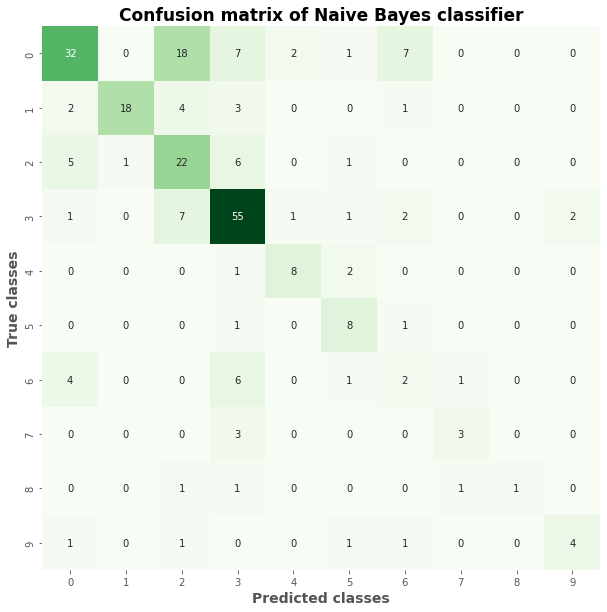

In [13]:
conf_matr(np.array(list(map(int, y_val_text))), np.argmax(y_pred, axis=1),0)

#### Random Forest 

In [14]:
#TUNING RANDOM FOREST
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 60, 80, 90],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [4, 6, 8],
    'n_estimators': [50, 80, 100, 200, 300]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(both_train, y_train_text)
y_pred = grid_search.predict_proba(both_val)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=1, min_samples_split=4, n_estimators=80; total time=   0.2s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=1, min_samples_split=6, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=2, min_samples_split=8, n_estimators=80; total time=   0.2s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=4, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=80; total time=   0.2s
[CV] END 

[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=1, min_samples_split=8, n_estimators=80; total time=   0.2s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=1, min_samples_split=8, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=8, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, max_features=3, min_samples_lea

[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=2, min_samples_split=4, n_estimators=80; total time=   0.2s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=2, min_samples_split=6, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=2, min_samples_split=8, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=4, n_estimators=80; total time=   0.2s
[CV] END bootstrap=True, max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, max_features=3, min_samples_leaf=2

[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=1, min_samples_split=4, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=2, min_samples_split=6, n_estimators=80; total time=   0.2s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=2, min_samples_split=8, n_estimators=80; total time=   0.2s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=4, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=50, max_features=3, min_samples_leaf=1

[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   0.9s
[CV] END bootstrap=True, max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=6, n_estimators=80; total time=   0.2s
[CV] END bootstrap=True, max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=8, n_estimators=80; total time=   0.2s
[CV] END bootstrap=True, max_depth=50, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=50, max_features=3, min_samples_leaf=2

[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=1, min_samples_split=8, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=2, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf

[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=1, min_samples_split=4, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   0.8s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, max_features=3, min_samples_lea

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(np.array(list(map(int, y_val_text))), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.71      0.88      0.79        67
           1       0.88      0.75      0.81        28
           2       0.57      0.60      0.58        35
           3       0.68      0.87      0.76        69
           4       1.00      0.55      0.71        11
           5       0.80      0.80      0.80        10
           6       0.67      0.14      0.24        14
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         8

    accuracy                           0.70       252
   macro avg       0.53      0.46      0.47       252
weighted avg       0.66      0.70      0.66       252



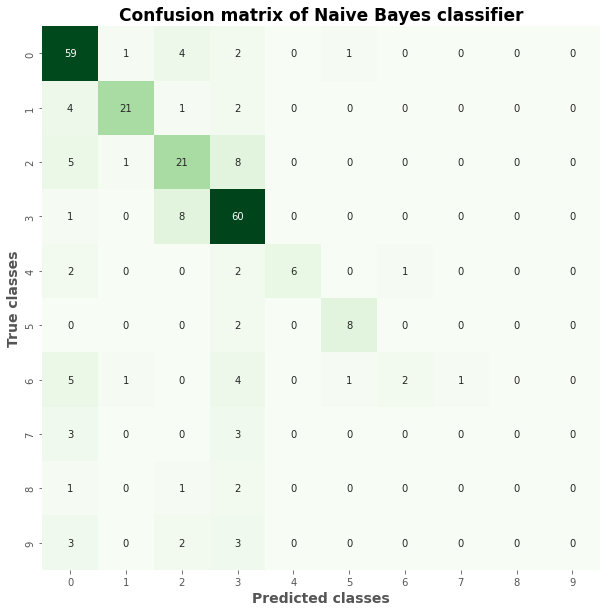

In [16]:
conf_matr(np.array(list(map(int, y_val_text))), np.argmax(y_pred, axis=1),1)

#### LGBM Classifier 

In [17]:
model = lgb.LGBMClassifier()
y_pred = model.fit(both_train, y_train_text,eval_set=[(both_val, y_val_text),(both_train, y_train_text)],
          verbose=20,eval_metric='logloss').predict_proba(both_val)

[20]	training's multi_logloss: 0.168699	valid_0's multi_logloss: 1.02105
[40]	training's multi_logloss: 0.0194948	valid_0's multi_logloss: 1.04663
[60]	training's multi_logloss: 0.00236696	valid_0's multi_logloss: 1.19466
[80]	training's multi_logloss: 0.000301106	valid_0's multi_logloss: 1.37502
[100]	training's multi_logloss: 5.54092e-05	valid_0's multi_logloss: 1.48187


In [18]:
params = {'learning_rate': [0.01, 0.05, 0.09], 'n_estimators': [8, 24, 32],
                'num_leaves': [6, 8, 12, 16], 'boosting_type': ['gbdt'], 
                'objective': ['binary'], 'seed': [500],
                'colsample_bytree': [0.65, 0.8], 
                'subsample': [0.7, 0.75], 'reg_alpha': [1, 2, 6],
                'reg_lambda': [1, 2], 'max_depth':[2, 5, 10, 20]}

grid_search = GridSearchCV(estimator = model,  
                           param_grid = params,
                           scoring = 'f1_weighted',
                           cv = 5,
                           verbose=0, n_jobs=-1)

grid_search.fit(both_train, y_train_text)
y_pred = grid_search.predict_proba(both_val)

In [19]:
print(classification_report(np.array(list(map(int, y_val_text))), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.71      0.81      0.76        67
           1       0.74      0.71      0.73        28
           2       0.57      0.60      0.58        35
           3       0.70      0.84      0.76        69
           4       0.70      0.64      0.67        11
           5       0.80      0.80      0.80        10
           6       0.75      0.21      0.33        14
           7       0.33      0.17      0.22         6
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         8

    accuracy                           0.68       252
   macro avg       0.53      0.48      0.49       252
weighted avg       0.65      0.68      0.66       252



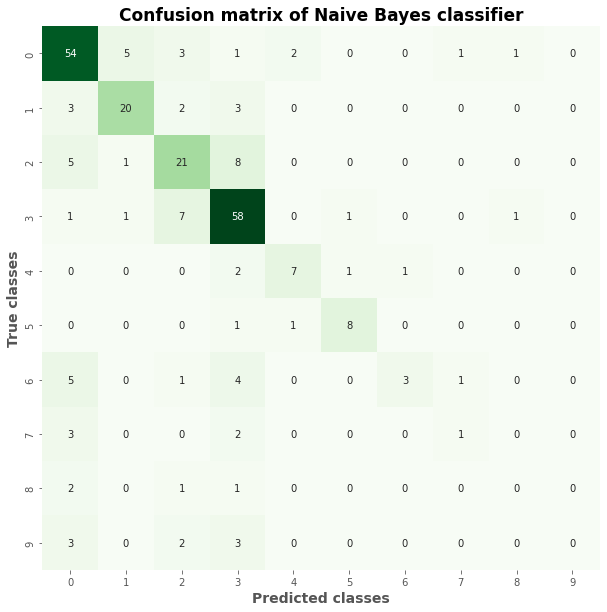

In [20]:
conf_matr(np.array(list(map(int, y_val_text))), np.argmax(y_pred, axis=1),2)

#### Logistic Regression 

In [30]:
#TUNING LOGISTIC REGRESSION
clf = LogisticRegression(max_iter=10000)
parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['none', 'l2']},
              {'C':[0.001, 0.01, 0.1, 1, 10, 100]},
              {'max_iter':[10000]}]

grid_search = GridSearchCV(estimator = clf,  
                           param_grid = parameters,
                           scoring = 'f1_weighted',
                           cv = 5,
                           verbose=0)

grid_search.fit(both_train, y_train_text)
y_pred = grid_search.predict_proba(both_val)

In [31]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(np.array(list(map(int, y_val_text))), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.77      0.84      0.80        67
           1       0.91      0.75      0.82        28
           2       0.67      0.57      0.62        35
           3       0.66      0.88      0.76        69
           4       0.73      0.73      0.73        11
           5       0.82      0.90      0.86        10
           6       0.50      0.14      0.22        14
           7       0.50      0.50      0.50         6
           8       0.00      0.00      0.00         4
           9       0.50      0.12      0.20         8

    accuracy                           0.72       252
   macro avg       0.61      0.54      0.55       252
weighted avg       0.70      0.72      0.69       252



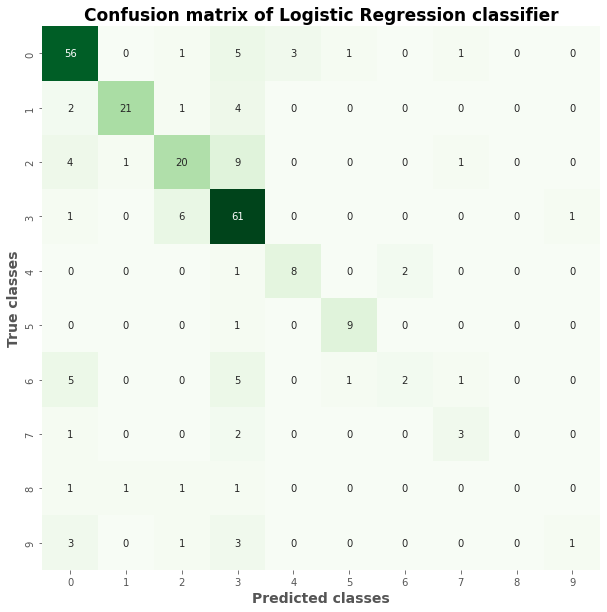

In [32]:
conf_matr(np.array(list(map(int, y_val_text))), np.argmax(y_pred, axis=1),3)

In [33]:
#Load data again for final submission
all_train = np.vstack((both_train,both_val))
all_y = np.concatenate((y_train_text,y_val_text)) #same with graph

grid_search.fit(all_train, all_y) #using logistic regression, which had the best results
y_pred = grid_search.predict_proba(both_test)

In [34]:
# Write predictions to a file
with open('sample_submission.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(10):
        lst.append('class_'+str(i))
    lst.insert(0, "domain_name")
    writer.writerow(lst)
    for i,test_domain in enumerate(test_domains):
        lst = y_pred[i,:].tolist()
        lst.insert(0, test_domain)
        writer.writerow(lst)